# Linear Chi-Squared Tutorial

For interpreting data, a quadtree can be a quick and easy way to constrain your model parameters with basic $\chi^2$ mapping. In this notebook, we'll implement a quadtree to calculate $\chi^2$ values in order to estimate the best-fit parameters for a linear model. `astroQTpy` makes this process simple with the `Chi2QuadTree` class.

### Define a model

To keep things simple for now, we'll create a linear model, generate some fake data from it, then attempt to recover the best-fit parameters by mapping $\chi^2$ as a function of the model parameters, $a$ and $b$.

$$f(x) = ax + b$$

In [1]:
def linear_model(x, params):
    """simple linear function that takes two parameters.
    
    """
    a, b = params # unpack parameters
    
    # equation for a line
    y = a * x + b
    
    return y

### Create a mock data set

Set our $a$ and $b$ parameters and other hyperparameters.

In [2]:
# set parameters
a_truth = -1.7
b_truth = 12.8
sigma = 1.1
N_data = 120

Generate some data and add random noise.

In [3]:
import numpy as np

# define domain
x_data = np.linspace(0, 10, N_data)

# generate fake data
y_data = linear_model(x_data, (a_truth, b_truth))
y_data += np.random.normal(0, sigma, N_data)  # add noise
data = np.stack((x_data, y_data))

# Gaussian weights
weights = np.full(N_data, 1/sigma**2)

Plot it!

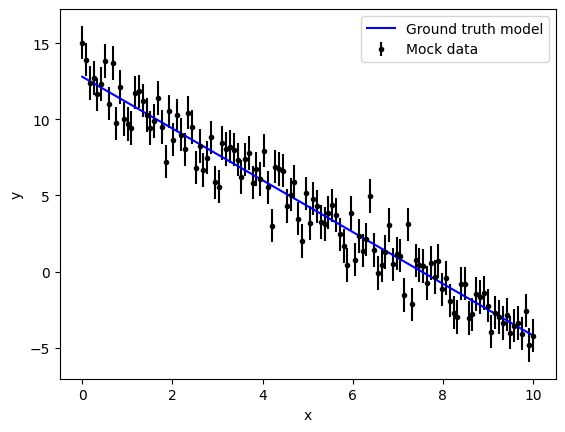

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.errorbar(*data, yerr=sigma, fmt='k.', label='Mock data')
ax.plot(x_data, linear_model(x_data, (a_truth, b_truth)), 'b-', label='Ground truth model')
ax.legend()

plt.show()

### Explore $\chi^2$ space with a quadtree

Now we can import the `Chi2QuadTree` quadtree class from `astroQTpy` and create a new instance.

In [5]:
from astroqtpy.quadtree import Chi2QuadTree

Let's pretend for now that we don't have very good priors of $a$ and $b$, so we want to explore a wide region of parameter space of $-20 < a < 20$ and $-10 < b < 30$. In addition to specifying these limits, we must also give `astroQTpy` our data as a numpy array with shape (2, N), as well as our callable model function with which it will calculate $\chi^2$ values. We'll also tell the code the statistical weights corresponbding to our data, which must be a numpy array with length N. Lastly, we'll tune some the optional parameters in `Chi2QuadTree` in order to get good results.

In [6]:
data.shape

(2, 120)

In [7]:
chi2_tree = Chi2QuadTree(-20, 20, -10, 30,
                         data,
                         linear_model,
                         weights=weights,
                         split_threshold=0.1,
                         N_proc=1,
                         N_points=50,
                         max_depth=7,
                         max_chi2=12,
                         filename_points='./tutorial_outputs/chi2tree_points.txt',
                         filename_nodes='./tutorial_outputs/chi2tree_nodes.txt'
                        )

Run the quadtree and plot the $\chi^2$ map!

In [8]:
chi2_tree.run_quadtree()

Attempting to load previous results...
   No previous results found, starting new...
DONE! :)


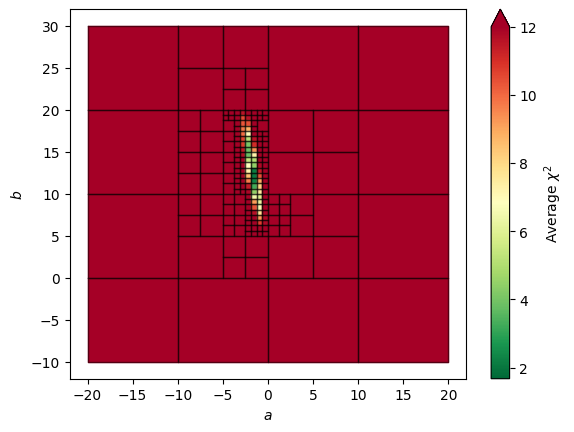

In [9]:
# make figure
fig, ax = plt.subplots()
quadtree_map = chi2_tree.draw_tree(ax, vmax=12)
plt.colorbar(quadtree_map, ax=ax, label='Average $\chi^2$', extend='max')
ax.set_xlabel("$a$")
ax.set_ylabel("$b$"); 

This gets us closer to the optimal model paramters, but we can do better! Let's create another quadtree map with tighter contraints on the initial paramater space.

### Refine the quadtree

In [10]:
chi2_tree = Chi2QuadTree(-5, 1, 5, 20,
                         data,
                         linear_model,
                         weights=weights,
                         split_threshold=0.1,
                         N_proc=1,
                         N_points=50,
                         max_depth=7,
                         max_chi2=12,
                         filename_points='./tutorial_outputs/chi2tree_fine_points.txt',
                         filename_nodes='./tutorial_outputs/chi2tree_fine_nodes.txt'
                        )

Run and plot the quadtree!

In [11]:
chi2_tree.run_quadtree()

Attempting to load previous results...
   No previous results found, starting new...
DONE! :)


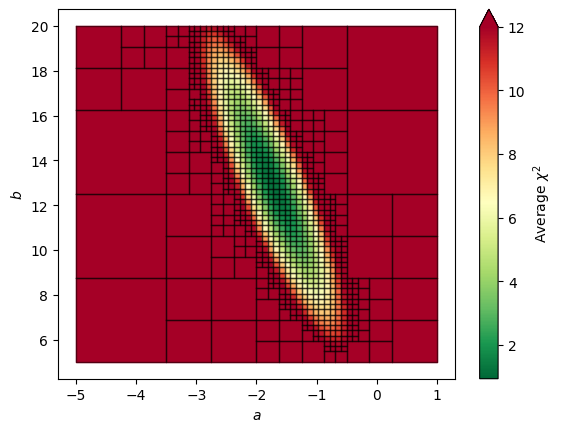

In [12]:
# make figure
fig, ax = plt.subplots()
quadtree_map = chi2_tree.draw_tree(ax, vmax=12)
plt.colorbar(quadtree_map, ax=ax, label='Average $\chi^2$', extend='max')
ax.set_xlabel("$a$")
ax.set_ylabel("$b$"); 

### Plot the best-fit model.

The `Chi2QuadTree` class has a built-in method to locate the point of minimum $\chi^2$. Note that we could further improve our estimates of the best-fit parameters if we increase the maximum depth of the quadtree or include more points per node.

All we need to do is call the `get_chi2_min` method to retrieve the QuadPoint object with the lowest $\chi^2$ value.

In [13]:
best_point = chi2_tree.get_chi2_min()
a_best = best_point.x
b_best = best_point.y

print(best_point)

QuadPoint(_x=-1.7263760412503126, _y=12.926878005460667, _value=1.131946638854931)


Let's plot the location of the best fit $a$ and $b$ parameters on the quadtree map.

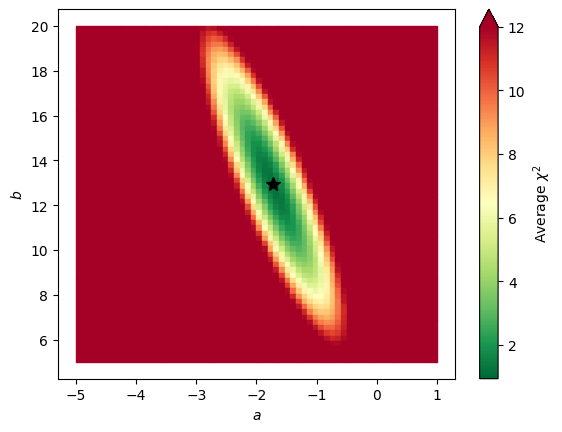

In [14]:
fig, ax = plt.subplots()
quadtree_map = chi2_tree.draw_tree(ax, show_lines=False, vmax=12)
plt.colorbar(quadtree_map, ax=ax, label='Average $\chi^2$', extend='max')
ax.plot(a_best, b_best, 'k*', ms=10)
ax.set_xlabel("$a$")
ax.set_ylabel("$b$"); 

And lastly, let's see how well our best-fit model compares to the data we simulated.

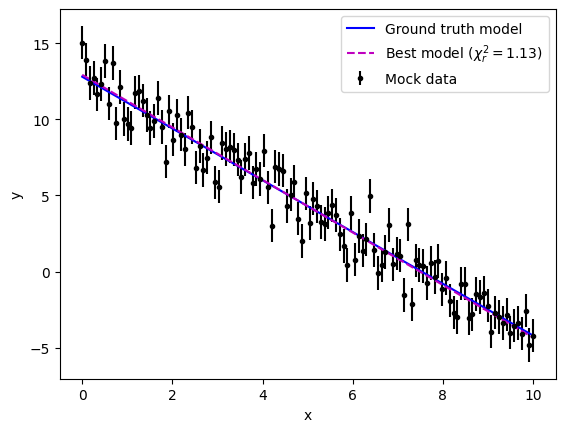

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.errorbar(*data, yerr=sigma, fmt='k.', label='Mock data')
ax.plot(x_data, linear_model(x_data, (a_truth, b_truth)), 'b-', label='Ground truth model')
ax.plot(x_data, linear_model(x_data, (a_best, b_best)), 'm--', label='Best model ($\chi_r^2 = {:.2f}$)'.format(best_point.value))
ax.legend()

plt.show()